In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

In [19]:
weather = pd.read_csv("../Weather/Weather.csv")
weather = weather.drop(columns=["%time"])
resource = pd.read_csv("../TheAutomators/Resources.csv")
climate = pd.read_csv("../TheAutomators/GreenhouseClimate.csv",encoding='utf-8')
climate=climate.astype(float)
climate.info()


C:\Users\ntuan\AppData\Local\Temp\ipykernel_2388\1907780899.py:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,20,22,23,25,27,29,31,33,35,37,39,41,43,44,45,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  climate = pd.read_csv("../TheAutomators/GreenhouseClimate.csv",encoding='utf-8')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47809 entries, 0 to 47808
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   %time                        47809 non-null  float64
 1   AssimLight                   47738 non-null  float64
 2   BlackScr                     47738 non-null  float64
 3   CO2ar                        47738 non-null  float64
 4   Cum_irr                      47738 non-null  float64
 5   EC_drain_PC                  47738 non-null  float64
 6   EnScr                        47738 non-null  float64
 7   HumDef                       47738 non-null  float64
 8   PipeGrow                     47738 non-null  float64
 9   PipeLow                      47738 non-null  float64
 10  Rhair                        47738 non-null  float64
 11  Tair                         47738 non-null  float64
 12  Tot_PAR                      47738 non-null  float64
 13  Tot_PAR_Lamps   

Xử lý dữ liệu cho model, model sẽ dưới dạng 3x3 matrix với shape [samples, timesteps, features]

In [20]:
sample_per_day = 288 # 5 phút 
N_days = len(weather) // sample_per_day

# Reshape input: [samples, timesteps, features]
X_seq = []
for i in range(N_days):
    start = i * sample_per_day
    end = start + sample_per_day
    X_seq.append(weather.iloc[start:end].values)

X_seq = np.array(X_seq)  # Shape: (166, 288, N_weather)
y = resource["Heat_cons"].values.reshape(-1,1)   # Shape: (166, N_resource)

# Standarize
scaler_X = StandardScaler()
X_seq_scaled = np.array([scaler_X.fit_transform(day) for day in X_seq])

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_seq_scaled, y_scaled, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (132, 288, 10), y_train shape: (132, 1)


Trong trường hợp cần tính correlation, sẽ lấy mean của 1 ngày làm căn cứ so sánh. Lúc này, kết quả sẽ là matrix 2x2 với row của 2 cá thể bằng nhau.

In [21]:
sample_per_day = 288
total_samples = len(weather)
num_days = total_samples // sample_per_day 

weather_agg = []

for i in range(num_days):
    start = i * sample_per_day
    end = start + sample_per_day
    window = weather.iloc[start:end]
    feature_vector = window.mean().values  
    weather_agg.append(feature_vector)

df_weather_avg = pd.DataFrame(weather_agg, columns=weather.columns)

print(df_weather_avg.shape)  # (166, N_weather)
print(resource.shape)        # (166, N_resource)   


(166, 10)
(166, 7)


In [38]:
sample_per_day = 288
total_samples = len(climate)
num_days = total_samples // sample_per_day 

climate_ag = []

for i in range(num_days):
    start = i * sample_per_day
    end = start + sample_per_day
    window = climate.iloc[start:end]
    feature_vector = window.mean().values  
    climate_ag.append(feature_vector)

df_climate_ag = pd.DataFrame(climate_ag, columns=climate.columns)

print(df_climate_ag.shape)  # (166, N_weather)
print(resource.shape)        # (166, N_resource)   


(166, 50)
(166, 7)


In [40]:
# Tính ma trận tương quan
def compute_correlation_matrix(df_X: pd.DataFrame, df_Y: pd.DataFrame) -> pd.DataFrame:
    corr_matrix = pd.DataFrame(index=df_X.columns, columns=df_Y.columns)
    for x_col in df_X.columns:
        for y_col in df_Y.columns:
            corr, _ = pearsonr(df_X[x_col], df_Y[y_col])
            corr_matrix.loc[x_col, y_col] = corr
    return corr_matrix.astype(float)



                               %Time   Heat_cons  ElecHigh   ElecLow  \
%time                        1.000000  -0.774348 -0.603900 -0.538097   
AssimLight                  -0.757868   0.745906  0.942461  0.870525   
BlackScr                    -0.728263   0.840943  0.745577  0.772511   
CO2ar                        0.132706   0.219633  0.474446  0.494165   
Cum_irr                      0.783053  -0.558642 -0.376691 -0.166416   
EC_drain_PC                  0.132771   0.112317  0.080974  0.185891   
EnScr                       -0.270956  -0.127132 -0.018431 -0.193091   
HumDef                       0.569924  -0.651768 -0.866275 -0.808361   
PipeGrow                     0.580715  -0.162285 -0.292377 -0.215006   
PipeLow                     -0.761078   0.962362  0.747486  0.733925   
Rhair                       -0.407662   0.574711  0.843503  0.811733   
Tair                         0.760307  -0.494923 -0.424055 -0.297272   
Tot_PAR                      0.837289  -0.618440 -0.451632 -0.26

Text(0.5, 1.0, 'Correlation Heatmap')

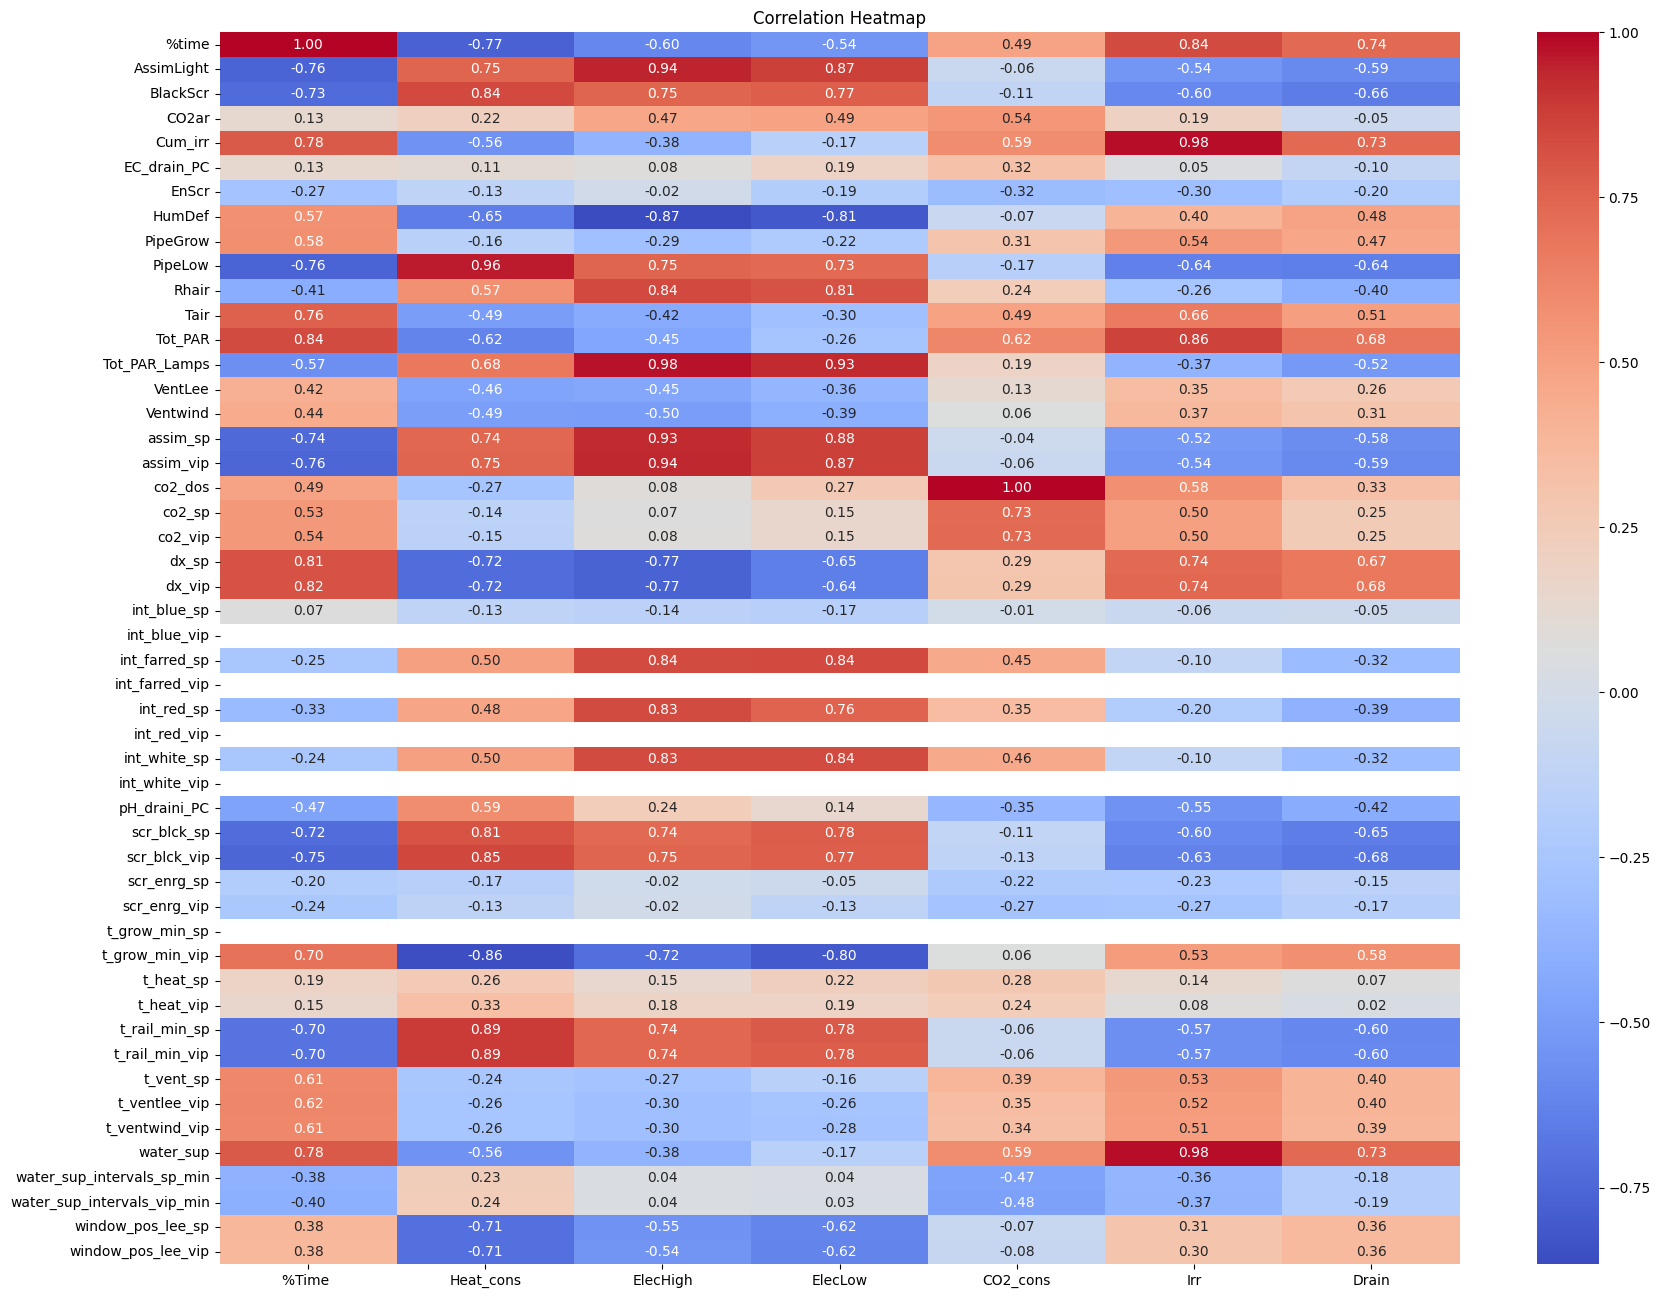

In [43]:
plt.figure(figsize=(20, 16))
corr_matrix = compute_correlation_matrix(df_climate_ag, resource)
print(corr_matrix) # Từ đây có thể vẽ heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Giả định bạn đã có: weather (DataFrame), resource (DataFrame)
train_features = climate[["AssimLight","BlackScr","PipeLow","scr_blck_vip","t_rail_min_vip"]]
# --- Tham số ---
sample_per_day = 288  # 5 phút
N_days = len(climate) // sample_per_day

# --- Tạo chuỗi dữ liệu ---
X_seq = []
for i in range(N_days):
    start = i * sample_per_day
    end = start + sample_per_day
    X_seq.append(train_features.iloc[start:end].values)

X_seq = np.array(X_seq)  # Shape: (N_days, 288, N_weather)

# --- Chọn chỉ 1 cột từ resource ---
y = resource["ElecHigh"].values.reshape(-1, 1)  # Shape: (N_days, 1)

# --- Chuẩn hóa ---
scaler_X = StandardScaler()
X_seq_scaled = np.array([scaler_X.fit_transform(day) for day in X_seq])
X_seq_scaled = np.nan_to_num(X_seq_scaled)  # xử lý NaN nếu có

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)
y_scaled = np.nan_to_num(y_scaled)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_seq_scaled, y_scaled, test_size=0.2, random_state=42)

# --- Tạo mô hình LSTM ---
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Dự đoán 1 feature
])

lstm_model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# --- Huấn luyện ---
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# --- Dự đoán ---
y_pred_scaled = lstm_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# --- Đánh giá ---
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² score: {r2:.4f}")


Epoch 1/500
4/4 [==============================] - 2s 160ms/step - loss: 1.0124 - mae: 0.8765 - val_loss: 1.0310 - val_mae: 0.8697
Epoch 2/500
4/4 [==============================] - 0s 53ms/step - loss: 1.0002 - mae: 0.8455 - val_loss: 1.0003 - val_mae: 0.8513
Epoch 3/500
4/4 [==============================] - 0s 41ms/step - loss: 0.9455 - mae: 0.8239 - val_loss: 0.9746 - val_mae: 0.8339
Epoch 4/500
4/4 [==============================] - 0s 37ms/step - loss: 0.8997 - mae: 0.7922 - val_loss: 0.9524 - val_mae: 0.8166
Epoch 5/500
4/4 [==============================] - 0s 33ms/step - loss: 0.8805 - mae: 0.7853 - val_loss: 0.9324 - val_mae: 0.8000
Epoch 6/500
4/4 [==============================] - 0s 35ms/step - loss: 0.8899 - mae: 0.7688 - val_loss: 0.9158 - val_mae: 0.7841
Epoch 7/500
4/4 [==============================] - 0s 31ms/step - loss: 0.8694 - mae: 0.7555 - val_loss: 0.8995 - val_mae: 0.7694
Epoch 8/500
4/4 [==============================] - 0s 29ms/step - loss: 0.8406 - mae: 0.7

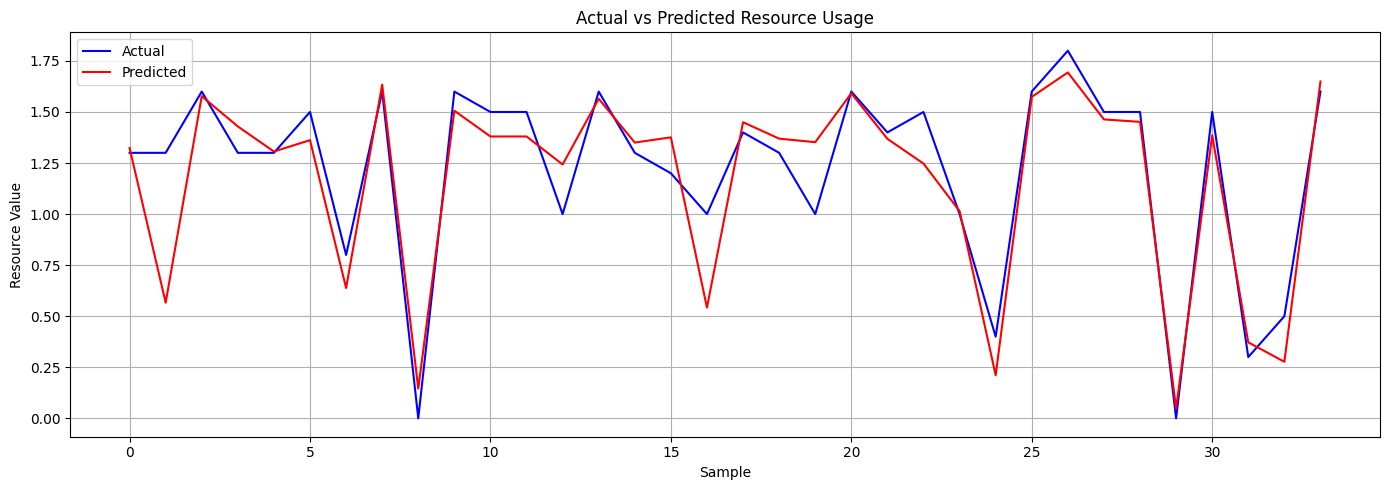

In [60]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Resource Usage')
plt.xlabel('Sample')
plt.ylabel('Resource Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


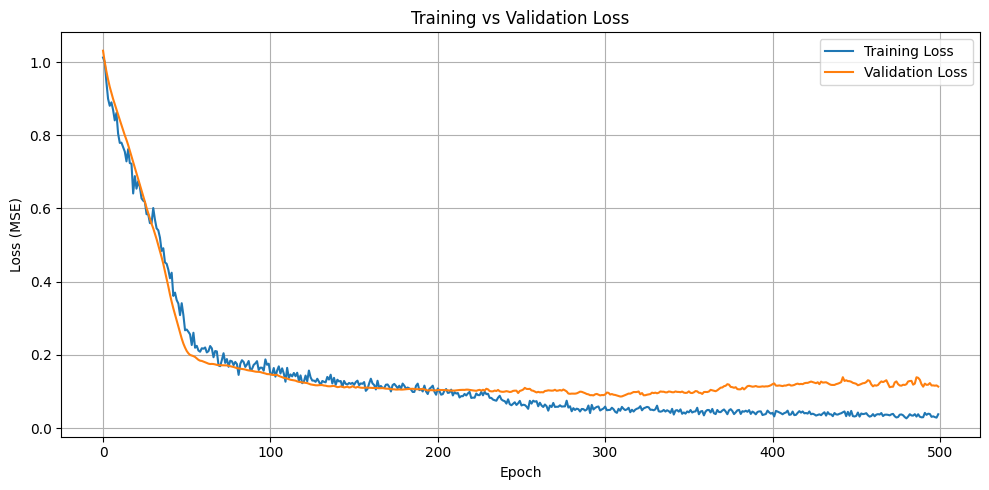

In [61]:
# Trích xuất loss từ history
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D

# Mô hình Temporal CNN
Tcnn_model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Regression output
])

Tcnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = Tcnn_model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, verbose=1)


Epoch 1/200
7/7 [==============================] - 1s 46ms/step - loss: 1.0625 - mae: 0.8925 - val_loss: 0.6549 - val_mae: 0.6252
Epoch 2/200
7/7 [==============================] - 0s 14ms/step - loss: 0.3437 - mae: 0.3818 - val_loss: 0.2783 - val_mae: 0.4483
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 0.2515 - mae: 0.3421 - val_loss: 0.3670 - val_mae: 0.4814
Epoch 4/200
7/7 [==============================] - 0s 13ms/step - loss: 0.1436 - mae: 0.2742 - val_loss: 0.1690 - val_mae: 0.3307
Epoch 5/200
7/7 [==============================] - 0s 13ms/step - loss: 0.0874 - mae: 0.1862 - val_loss: 0.1777 - val_mae: 0.3598
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 0.0872 - mae: 0.1987 - val_loss: 0.2400 - val_mae: 0.4007
Epoch 7/200
7/7 [==============================] - 0s 11ms/step - loss: 0.0787 - mae: 0.1900 - val_loss: 0.1384 - val_mae: 0.3285
Epoch 8/200
7/7 [==============================] - 0s 10ms/step - loss: 0.0633 - mae: 0.15

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_scaled = Tcnn_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² score: {r2:.4f}")


2/2 [==============================] - 0s 34ms/step
MAE: 0.1670
MSE: 0.0389
R² score: 0.8210


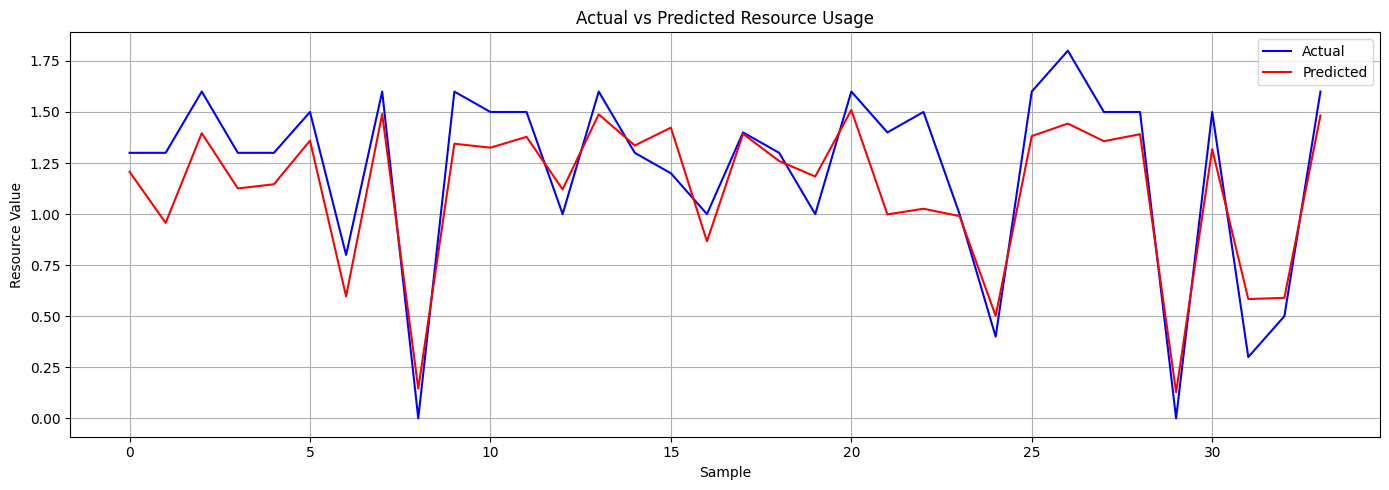

In [49]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(y_true, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Resource Usage')
plt.xlabel('Sample')
plt.ylabel('Resource Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

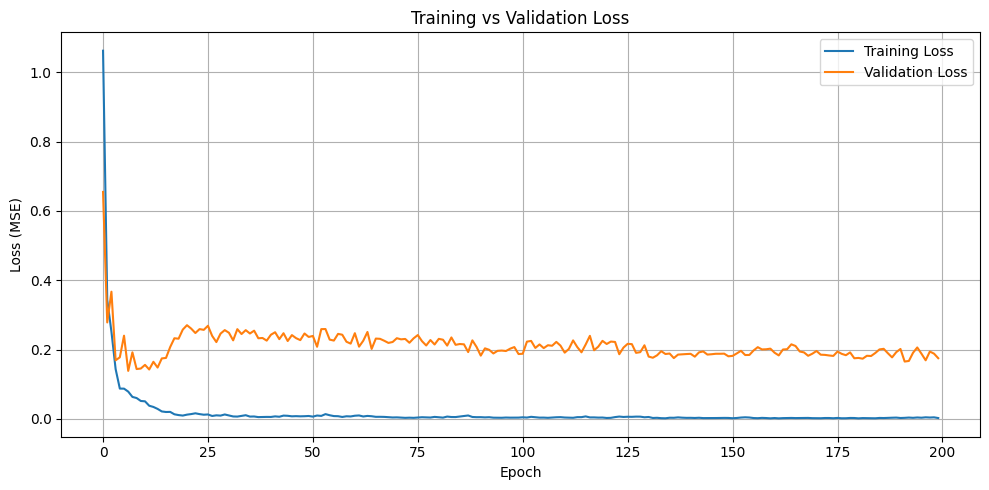

In [52]:
# Trích xuất loss từ history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()